# Long-range CNOT Gate teleportation using dynamic circuits

## Step 1: Map the problem to circuits and operators

In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_dynamic_CNOT_circuit(num_qubits):
    '''
    (1) 1D chains of nearest neighbours
    (2) 0th Qubit is the control, and the last qubit is the target.
    (2) The control qubit starts in the + state
    '''
    num_ancilla = num_qubits - 2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubits)
    crl1 = ClassicalRegister(num_ancilla_pair, name = 'crl1') # the parity-controlled X gate
    crl2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name = 'crl2') # The parity-controlled Z gate
    crl3 = ClassicalRegister(2, name = 'crl3') # For the final measurment on the control and target qubits
    qc = QuantumCircuit(qr, crl1, crl2, crl3)

    # Initilize the control qubit
    qc.h(0)
    qc.barrier()

    # Entangle the  control qubit and the first ancilla qubit
    qc.cx(0,1)

    # Create Bell pairs on ancilla qubits
    # The first anicll qubit in index q
    for i in range(num_ancilla_pair):
        qc.h(2 + 2 * i)
        qc.cx(2 + 2 * i, 2 + 2 * i + 1)

    
    # Prepare Bell pairs on staggered aniclla and data qubits
    for i in range(num_ancilla_pair + 1):
        qc.cx(1 + 2*i, 1 + 2*i + 1)
    for i in range(1, num_ancilla_pair + 2):
        qc.h(2*i-1)


    # Measurement on alternating ancilla qubits starting with the first one
    # keep track of the parity for eventual condidtional Z gate.
    for i in range(1, num_ancilla_pair + 2):
        qc.measure(2*i - 1, crl2[i-1])
        if i == 1: 
            parity_control = expr.lift(crl2[i-1])
        else: 
            parity_control = expr.bit_xor(crl2[i-1], parity_control)

    # Measurement on staggered alternating ancilla qubits withe the second.
    # Keep track of the parity of eventual conditional X gate.
    for i in range(num_ancilla_pair):
        qc.measure(2*i + 2, crl1[i])
        if i == 0:
            parity_target = expr.lift(crl1[i])
        else: 
            parity_control = expr.bit_xor(crl1[i], parity_target)
    with qc.if_test(parity_control): 
        qc.z(0)
    with qc.if_test(parity_target):
        qc.x(-1)

    return qc 

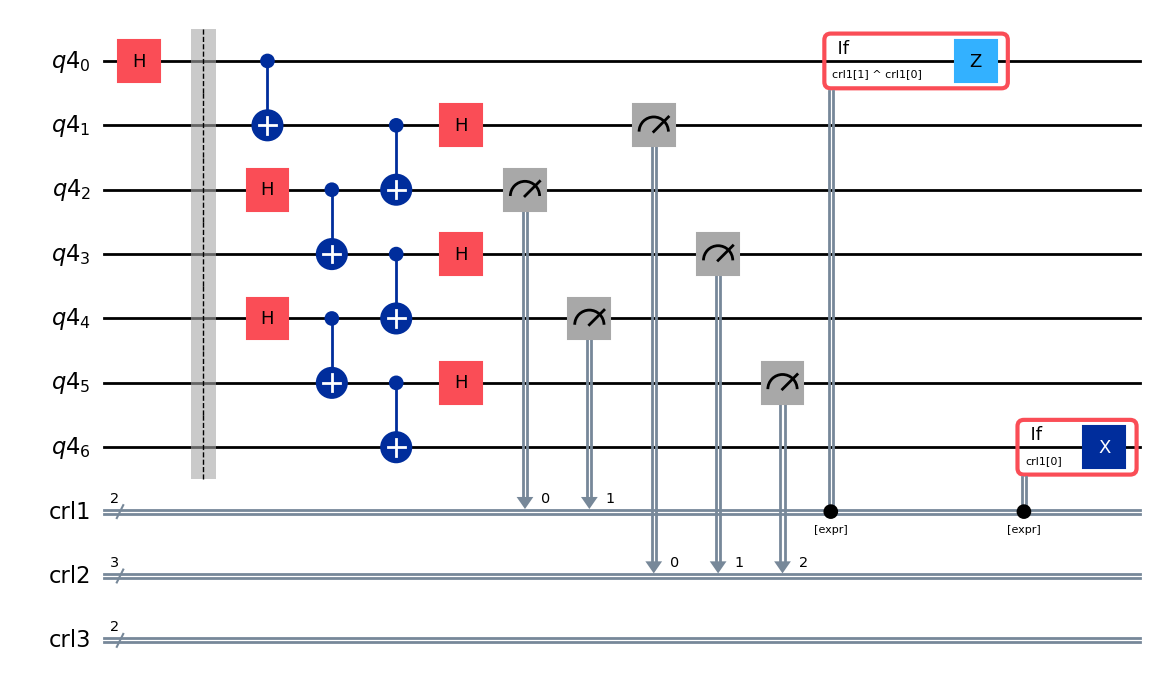

In [10]:
qc = get_dynamic_CNOT_circuit(num_qubits=7)
qc.draw(output = 'mpl')

In [11]:
max_num_qubit = 41

qc_list = []
num_qubit_list = list(range(7, max_num_qubit + 1, 2))
for num_qubit in num_qubit_list:
    qc_list.append(get_dynamic_CNOT_circuit(num_qubit))

## Step 2: Optimize the problem for quantum execution



In [13]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

## Step 3: Execute the circuit on quantum hardware

In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id())

crxpxrzarde0008geq1g


Step 4: Post processing and plotting

In [15]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'crxpxrzarde0008geq1g' 

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

list_Bell = []
list_other = []
for i in range(0, len(qc_list)):
    data = result[i+1].data
    counts = data.crl3.get_counts()
    total_counts = data.crl3.num_shots

    prob_Bell = (counts['00'] + counts['11']) / total_counts

    list_Bell.append(prob_Bell)
    list_other.append(1-prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label = '00 or 11')
plt.plot(num_qubit_list, list_other, '-^', label = 'other')
plt.ylabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()